In [1]:
# notebook to elucidate the secrets of the simple reactor solver
# (and maybe compare results to Cantera)

In [2]:
import rmgpy.chemkin
import os

import cantera as ct
import numpy as np
import logging

import rmgpy.solver  # import SimpleReactor, TerminationTime, SurfaceReactor
import rmgpy.quantity  #import Quantity
import rmgpy.rmg.listener # import SimulationProfileWriter, SimulationProfilePlotter
import rmgpy.rmg.settings  #import ModelSettings, SimulatorSettings

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# logging.basicConfig(level=logging.DEBUG)



In [3]:
sevy_mech = '/home/moon/rmg/RMG-Py/test/rmgpy/test_data/chemkin/chemkin_py/surface/'
s_chemkin = os.path.join(sevy_mech, 'chem-gas.inp')
s_chemkin_surface = os.path.join(sevy_mech, 'chem-surface.inp')
s_dict = os.path.join(sevy_mech, 'species_dictionary.txt')
species_list_gas, reaction_list_gas = rmgpy.chemkin.load_chemkin_file(s_chemkin, s_dict)
species_list_surf, reaction_list_surf = rmgpy.chemkin.load_chemkin_file(s_chemkin_surface, s_dict)

output_directory = 'surface_csvs'

os.makedirs(output_directory, exist_ok=True)

# Cantera version

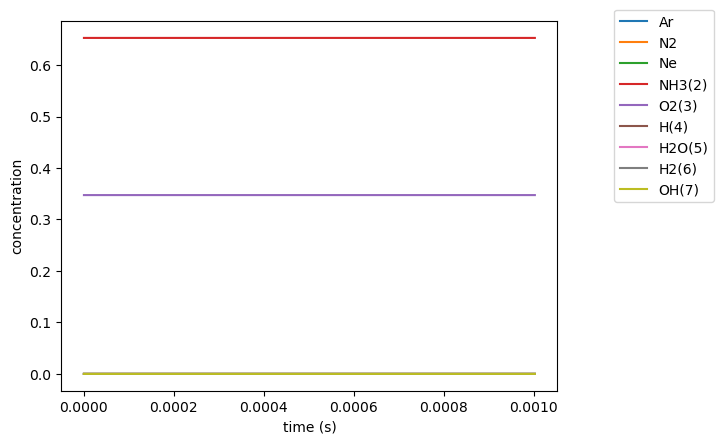

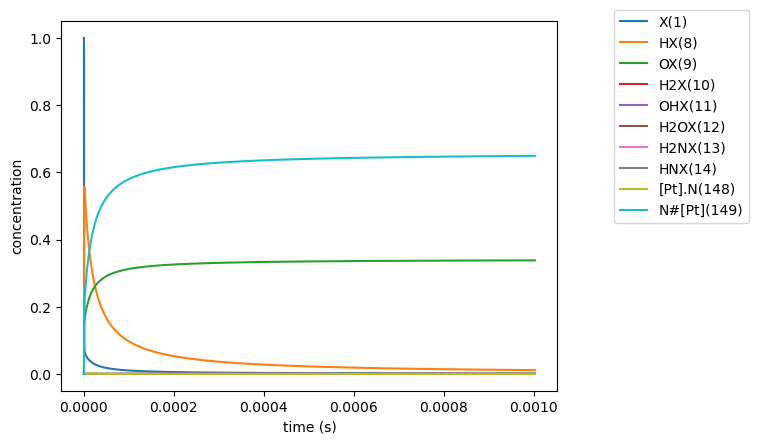

In [4]:
mech_yaml = '/home/moon/rmg/RMG-Py/test/rmgpy/test_data/chemkin/chemkin_py/surface/chem-gas.yaml'
# mech_yaml = '/home/moon/uncertainty_estimator/cpox_pt/cpox_pt_20241112/og_lib/cantera/chem_annotated.yaml'
mech_yaml = '/home/moon/uncertainty_estimator/cpox_pt/cpox_rh_20241112/mincat/cantera/chem_annotated.yaml'
mech_yaml = '/home/moon/uncertainty_estimator/cpox_pt/cpox_rh_emily/chem_annotated-gas.yaml'


mech_yaml = '/home/moon/nitridation/fe110_20241206/chem_annotated.yaml'


# gas, _ = ct.import_phases(mech_yaml, ["gas", "surface1"])
# surf = ct.Interface(mech_yaml, 'surface1')

surf = ct.Interface(mech_yaml, 'surface1')
gas = surf.adjacent['gas']

T = 700.0
P = ct.one_atm

# Nitridation
initial_mole_fractions = 'NH3(2):0.5, O2(3):0.5'
initial_surface_coverages = 'X(1):1.0'


# # Emily's numbering
# initial_mole_fractions = 'CH4(2):0.5, O2(3):0.5'
# initial_surface_coverages = 'X(1):1.0'

# initial_mole_fractions = 'CH4:0.5, O2:0.5'  # test data
# initial_surface_coverages = 'X:1.0'

gas.TPY = T, P, initial_mole_fractions
surf.TP = T, P
surf.coverages = initial_surface_coverages

catalyst_weight = 4.24e-3
cat_site_per_wt = 5*61.67*1e-6*1e3 # [mol/kg] 1e-6mol/micromole, 1000g/kg
site_density = (
    surf.site_density * 1000
)  # [mol/m^2]cantera uses kmol/m^2, convert to mol/m^2
cat_area = (catalyst_weight * cat_site_per_wt) / site_density  # [m^3]

# gas_reactor = ct.IdealGasReactor(gas, energy='off')
# gas_reactor.volume = 6.0
gas_reactor = ct.IdealGasConstPressureReactor(gas, energy='off')
# opting not to set catalyst area here... we'll see how that goes


surface_reactor = ct.ReactorSurface(surf, gas_reactor)

net = ct.ReactorNet([gas_reactor])



#########


# upstream = ct.Reservoir(gas, name='upstream')

# # # create a reservoir for the reactor to exhaust into. The composition of
# # # this reservoir is irrelevant.
# downstream = ct.Reservoir(gas, name='downstream')

# V = 30 # velocity m/s (setting very high values allows for effectively fixed gas-phase composition)

# mass_flow_rate = V * gas.density * 1.0 * 1.0
# # # The mass flow rate into the reactor will be fixed by using a
# # # MassFlowController object.
# m = ct.MassFlowController(upstream, gas_reactor, mdot=mass_flow_rate)

# v = ct.PressureController(gas_reactor, downstream, master=m, K=1e-5)
##############

history = []
gas_history = []

ts_ct = [net.time]
ys_ct = [gas.X]
ys_surf = [surf.coverages]
while net.time < 1e-3:
    net.step()
    ts_ct.append(net.time)
    ys_ct.append(gas.X)
    ys_surf.append(surf.coverages)

# plot results
for i in range(len(ys_ct[0])):
    y_hs = [x[i] for x in ys_ct]
    plt.plot(ts_ct, y_hs, label=gas.species_names[i])
plt.xlabel('time (s)')
plt.ylabel('concentration')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

for i in range(len(ys_surf[0])):
    y_hs = [x[i] for x in ys_surf]
    plt.plot(ts_ct, y_hs, label=surf.species_names[i])
plt.xlabel('time (s)')
plt.ylabel('concentration')
# plt.yscale('log')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()


In [ ]:
net.atol

In [ ]:
net.rtol

In [ ]:
gas.species()

In [ ]:
# nothing is happening on the surface

In [ ]:
# plot results
for i in range(len(gas_history[0])):
    y_hs = [x[i] for x in gas_history]
    plt.plot(t, y_hs, label=gas.species_names[i])
plt.xlabel('time (s)')
plt.ylabel('concentration')
plt.legend()

In [ ]:
surface_reactor = ct.ReactorSurface(surf, gas_reactor, A=cat_area)

In [ ]:
#######################################################################
# Input Parameters
#######################################################################
CH4_0 = 0.29577464788732394
O2_0 = 0.14788732394366197
Ar_0 = 1.0 - CH4_0 - O2_0


REACTOR_VOLUME = 1.0  # m^3
REACTOR_TEMPERATURE = 273.15  # K
REACTOR_PRESSURE = ct.one_atm
MAX_SIMULATION_TIME = 1.0
CONCENTRATIONS = {
    'CH4(2)': CH4_0,
    'O2(3)': O2_0,
    'Ar': Ar_0,
}


# initialize T and P
gas.TPX = REACTOR_TEMPERATURE, REACTOR_PRESSURE, CONCENTRATIONS
surf.TP = REACTOR_TEMPERATURE, REACTOR_PRESSURE

volume_flow = 1.0

# Catalyst settings (really need to double check these)
catalyst_weight = 4.24e-3
cat_site_per_wt = 5*61.67*1e-6*1e3 # [mol/kg] 1e-6mol/micromole, 1000g/kg
site_density = (
    surf.site_density * 1000
)  # [mol/m^2]cantera uses kmol/m^2, convert to mol/m^2
cat_area = (catalyst_weight * cat_site_per_wt) / site_density  # [m^3]
surf.coverages = "X(1):1.0"


gas_reactor = ct.IdealGasReactor(gas, energy='off')
gas_reactor.volume = REACTOR_VOLUME
surface_reactor = ct.ReactorSurface(surf, gas_reactor, A=cat_area)

# set up mass flow controllers
inlet = ct.Reservoir(gas)
exhaust = ct.Reservoir(gas)

N = 1001
t_end = 1.0e-5
t = np.linspace(0, t_end, N)
delta_t = t[1] - t[0]

X_cov = np.zeros(len(t))
# CH_cov = np.zeros(len(t))
# O_cov = np.zeros(len(t))
# CO2_cov = np.zeros(len(t))

history = []
gas_history = []

for i in range(0, len(t)):
    X_cov[i] = surf.coverages[surf.species_names.index('X(1)')]
#     CO_cov[i] = surf.coverages[surf.species_names.index('OCX(14)')]
#     O_cov[i] = surf.coverages[surf.species_names.index('OX(8)')]
#     CO2_cov[i] = surf.coverages[surf.species_names.index('CO2X(13)')]
    history.append(surf.coverages)
    gas_history.append(surf.adjacent['gas'].X)
    surf.advance_coverages(delta_t)
    
    
# plt.plot(t, X_cov)
# plt.xlabel('time (s)')

In [ ]:
gas = ct.Solution('/home/moon/rmg/RMG-Py/test/rmgpy/test_data/chemkin/chemkin_py/surface/chem-gas.yaml')

T = 1500.0
P = 100000.0
initial_mole_fractions='H2(1):0.67, O2(2):0.33'
gas.TPX = T, P, initial_mole_fractions

# reactor = ct.IdealGasReactor(gas)
reactor = ct.IdealGasConstPressureReactor(gas, energy='off')  # isothermal
net = ct.ReactorNet([reactor])
ts_ct = [net.time]
ys_ct = [reactor.thermo.X]
while net.time < 1e-1:
    net.step()
    ts_ct.append(net.time)
    ys_ct.append(reactor.thermo.X)

# plot results
for i in range(len(ys_ct[0])):
    y_hs = [x[i] for x in ys_ct]
    plt.plot(ts_ct, y_hs, label=gas.species_names[i])
plt.xlabel('time (s)')
plt.ylabel('concentration')
plt.legend()

# RMG simple.pyx

In [6]:
# sevy_mech = '/home/moon/rmg/RMG-Py/test/rmgpy/test_data/chemkin/chemkin_py/surface/'
# s_chemkin = os.path.join(sevy_mech, 'chem-gas.inp')
# s_chemkin_surface = os.path.join(sevy_mech, 'chem-surface.inp')
# s_dict = os.path.join(sevy_mech, 'species_dictionary.txt')


# sevy_mech = '/home/moon/uncertainty_estimator/cpox_pt/cpox_rh_emily'
# s_chemkin = os.path.join(sevy_mech, 'chem_annotated-gas.inp')
# s_chemkin_surface = os.path.join(sevy_mech, 'chem_annotated-surface.inp')
# s_dict = os.path.join(sevy_mech, 'species_dictionary.txt')


sevy_mech = '/home/moon/nitridation/fe110_20241206/'
s_chemkin = os.path.join(sevy_mech, 'chem_annotated-gas.inp')
s_chemkin_surface = os.path.join(sevy_mech, 'chem_annotated-surface.inp')
s_dict = os.path.join(sevy_mech, 'species_dictionary.txt')

species_list_gas, reaction_list_gas = rmgpy.chemkin.load_chemkin_file(s_chemkin, s_dict)
species_list_surf, reaction_list_surf = rmgpy.chemkin.load_chemkin_file(s_chemkin_surface, s_dict)

species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(s_chemkin, s_dict, surface_path=s_chemkin_surface)

output_directory = 'surface_csvs'

os.makedirs(output_directory, exist_ok=True)

In [ ]:
species_list[9]

In [ ]:
T = (700, 'K')
P = (1, 'bar')
termination_time = (1.0e-3, 's')
termination = [rmgpy.solver.TerminationTime(rmgpy.quantity.Quantity(termination_time))]
sensitivity_threshold=1e-3

# NH3 mech
initial_mole_fractions = {
    species_list[4]: 0.5,  # O2
    species_list[3]: 0.5,  # NH3
}
initial_surface_coverages = {
    species_list[9]: 1.0
}

# # emily mech
# initial_mole_fractions = {
#     species_list[4]: 0.5,  # O2
#     species_list[3]: 0.5,  # CH4
# }
# initial_surface_coverages = {
#     species_list[22]: 1.0
# }

# # test data
# initial_mole_fractions = {
#     species_list[5]: 0.5,  # O2
#     species_list[4]: 0.5,  # CH4
# }
# initial_surface_coverages = {
#     species_list[6]: 1.0
# }

sensitive_species = []

# surface_volume_ratio = (1600, 'm^-1')  # Emily says she made this up. I respect that
surface_volume_ratio = (20, 'm^-1')  # Emily says she made this up. I respect that
surface_site_density = (2.7200E-09, 'mol/cm^2')


reaction_system = rmgpy.solver.SurfaceReactor(
    T,
    P,
    initial_mole_fractions,
    initial_surface_coverages,
    surface_volume_ratio,
    surface_site_density,
    n_sims=1,
    termination=[],
    sensitive_species=[]
)

reaction_system.initialize_model(
    species_list,
    reaction_list,
    [],
    [],
#     surface_species=[x for x in species_list if x.contains_surface_site()],
#     surface_reactions=[x for x in reaction_list if x.is_surface_reaction()],
)

In [ ]:

# Options controlling the ODE simulations:
initial_time = 1e-12  # The time at which to initiate the simulation, in seconds
time_step = 10 ** 0.1  # The multiplicative factor to use between consecutive time points
# time_step = 10 ** 0.05  # The multiplicative factor to use between consecutive time points
# abs_tol = 1e-16  # The absolute tolerance to use in the ODE simluations
# rel_tol = 1e-8  # The relative tolerance to use in the ODE simulations

abs_tol = 1e-15  # The absolute tolerance to use in the ODE simluations
rel_tol = 1e-9  # The relative tolerance to use in the ODE simulations


terminated = False
next_time = initial_time
step_time = initial_time

times = [reaction_system.t]
# ys = [reaction_system.y]
ys = [reaction_system.core_species_concentrations]


tlist = np.logspace(-13, -3, 81, dtype=float)
t = [reaction_system.t]
for t1 in tlist:
    reaction_system.advance(t1)
    t.append(reaction_system.t)
    ys.append(reaction_system.core_species_concentrations)
    
# while reaction_system.t < termination_time[0]:
#     # Integrate forward in time to the next time point
#     reaction_system.step(step_time)

#     if reaction_system.t >= 0.9999 * next_time:
#         next_time *= time_step
#         times.append(reaction_system.t)
#         ys.append(reaction_system.core_species_concentrations)
# #         ys.append(reaction_system.y)

#     # Increment destination step time if necessary
#     if reaction_system.t >= 0.9999 * step_time:
#         step_time *= 10.0

In [ ]:
len(t)

In [ ]:
# skip surface
for i in range(len(ys[0])):
    if species_list[i].contains_surface_site():
        continue
    y_hs = [x[i] for x in ys]
    plt.plot(t, y_hs / np.sum(ys[0]), label=str(species_list[i]))
plt.xlabel('time (s)')
plt.ylabel('concentration')
plt.legend()

In [ ]:
# skip surface
for i in range(len(ys[0])):
    if not species_list[i].contains_surface_site():
        continue
    y_hs = [x[i] for x in ys]
    plt.plot(t, y_hs / np.sum(ys[0]), label=str(species_list[i]))
plt.xlabel('time (s)')
plt.ylabel('concentration')
plt.legend()

In [ ]:
len(ys)

In [ ]:
len(t)

In [ ]:
for i in range(len(ys[0])):
    y_hs = [x[i] for x in ys]
    plt.plot(times, y_hs / np.sum(ys[0]), label=str(species_list[i]))
plt.xlabel('time (s)')
plt.ylabel('concentration')
plt.legend()

In [ ]:
# plot on top of each other

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

assert len(ys[0]) == len(ys_ct[0])

for i in range(len(ys[0])):
    y_hs = [x[i] for x in ys]
    plt.plot(times, y_hs / np.sum(ys[0]), marker='.', color=colors[i % len(colors)], label=str(species_list[i]), linestyle='dotted')
    
    y_hs = [x[i] for x in ys_ct]
    plt.plot(ts_ct, y_hs, color=colors[i % len(colors)], linestyle='dashed', alpha=0.5)
    
    
    
plt.xlabel('time (s)')
plt.ylabel('concentration')
plt.legend()

# RMG simulate function

In [11]:
# RMG using the simulate function
T = (700, 'K')
P = (1, 'bar')
termination_time = (1.0e-3, 's')
termination = [rmgpy.solver.TerminationTime(rmgpy.quantity.Quantity(termination_time))]
sensitivity_threshold=1e-3

# NH3 mech
initial_mole_fractions = {
    species_list[4]: 0.5,  # O2
    species_list[3]: 0.5,  # NH3
}
initial_surface_coverages = {
    species_list[9]: 1.0
}


sensitive_species = [species_list[4]]
sensitive_species = []

# surface_volume_ratio = (1600, 'm^-1')  # Emily says she made this up. I respect that
surface_volume_ratio = (20, 'm^-1')  # Emily says she made this up. I respect that
surface_site_density = (2.7200E-09, 'mol/cm^2')

reaction_system = rmgpy.solver.SurfaceReactor(
    T,
    P,
    initial_gas_mole_fractions=initial_mole_fractions,
    initial_surface_coverages=initial_surface_coverages,
    surface_volume_ratio=surface_volume_ratio,
    surface_site_density=surface_site_density,
    n_sims=1,
    termination=[termination],
    sensitive_species=[]
)

reaction_system.initialize_model(
    species_list,
    reaction_list,
    [],
    [],
)

In [12]:
# Create the csv worksheets for logging sensitivity
output_directory = 'surf_sensitivity_calcs'
os.makedirs(output_directory, exist_ok=True)
rmgpy.util.make_output_subdirectory(output_directory, 'solver')
sens_worksheet = []
reaction_system_index = 0
for spec in reaction_system.sensitive_species:
    csvfile_path = os.path.join(output_directory, 'solver',
                                'sensitivity_{0}_SPC_{1}.csv'.format(reaction_system_index + 1, spec.index))
    sens_worksheet.append(csvfile_path)

# reaction_system.attach(rmgpy.rmg.listener.SimulationProfileWriter(
#     output_directory, reaction_system_index, species_list))
# reaction_system.attach(rmgpy.rmg.listener.SimulationProfilePlotter(
#     output_directory, reaction_system_index, species_list))

simulator_settings = rmgpy.rmg.settings.SimulatorSettings()  # defaults

model_settings = rmgpy.rmg.settings.ModelSettings()  # defaults
model_settings.tol_move_to_core = 0.1
model_settings.tol_interrupt_simulation = 1.0
model_settings.tol_keep_in_edge = 0.0

print('starting simulation')
reaction_system.simulate(
    core_species=species_list,
    core_reactions=reaction_list,
    edge_species=[],
    edge_reactions=[],
    surface_species=[],
    surface_reactions=[],
#     surface_species=[x for x in species_list if x.contains_surface_site()],
#     surface_reactions=[x for x in reaction_list if x.is_surface_reaction()],
    model_settings=model_settings,
    simulator_settings=simulator_settings,
    sensitivity=False,
#     sens_worksheet=sens_worksheet,
)

starting simulation


ERROR:root:Trying to step from time 0.0 to 9.999999999999998e+21 resulted in a solver (DASPK) error: DASPK returned with an IDID = -6, Repeated error test failures occurred on the last attempted step in DDASPK.  A singularity in the solution may be present.  If you are absolutely certain you want to continue, you should restart the integration.  (Provide initial values of Y and YPRIME which are consistent.)
ERROR:root:Model Resurrection has failed
ERROR:root:Core species names: ['Ar', 'N2', 'Ne', 'NH3(2)', 'O2(3)', 'H(4)', 'H2O(5)', 'H2(6)', 'OH(7)', 'X(1)', 'HX(8)', 'OX(9)', 'H2X(10)', 'OHX(11)', 'H2OX(12)', 'H2NX(13)', 'HNX(14)', '[Pt].N(148)', 'N#[Pt](149)']
ERROR:root:Core species moles: array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.99968338e-01,
        4.99976254e-01,  4.57261997e-25,  4.74922798e-05,  1.48997087e-22,
        1.78135071e-11, -7.04957805e-25, -2.70888939e-27, -1.57522533e-11,
        2.27759159e-36, -9.25207926e-23, -1.99360419e-32,  8.30425087e-24,

 DASPK--  AT T (=R1) AND STEPSIZE H (=R2) THE                                    
      In above,  R1 =  0.4740787143661D+22   R2 =  0.3841119706780D+07
 DASPK--  ERROR TEST FAILED REPEATEDLY OR WITH ABS(H)=HMIN                       


ValueError: invalid_objects could not be filled during resurrection process